# Model with biomass reaction to predict steady-state concentrations

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- Light spectrum & intensity (400-700 nm)
- Pigment concentrations: Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin
- Chlorophyll concentration in sample cuvette

### Output

Concentrations of ATP, NADPH, 3PGA

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"concregression_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 3

# # Setup the email sender
# email = SMTPMailSender(
#     SMTPserver='mail.gmx.net',
#     username='tobiaspfennig@gmx.de',
#     default_destination='tobiaspfennig@gmx.de'
# )

# email.send_email(
#     body=f"Regression run {file_prefix} was successfully started",
#     subject="Regression started"
# )

# Define OCP activation as active, light involved process with passive reversal
def OCPactivation(
    OCP, light_ocp, kOCPactivation, kOCPdeactivation, lcf, OCPmax=1
):  # >> changed: added <<
    return (
        light_ocp * lcf * kOCPactivation * (OCPmax - OCP)
        - kOCPdeactivation * OCP
    )


# Add OCP effect on light absorption
def ps_normabsorption_ocp(time, PBS_PS1, PBS_PS2, OCP, complex_abs_ps1, complex_abs_ps2, complex_abs_pbs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs_ps1 + complex_abs_pbs * PBS_PS1 * (1 - OCP)) / PSItot
    light_ps2 = (
        complex_abs_ps2 + complex_abs_pbs * PBS_PS2 * (1 - OCP)
    ) / PSIItot

    if isinstance(light_ps2, float) and isinstance(
        time, np.ndarray
    ):  # >> changed: added <<
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return light_ps1 * lcf, light_ps2 * lcf  # Get float values


def make_light_into_input(m, y0={}, init_param=None, verbose=True):
    if verbose:
        print("making absorption direct input")

    # Add the light parameters that were added as direct inputs
    p = {
        "complex_abs_ps1": 1,
        "complex_abs_ps2": 1,
        "complex_abs_pbs": 1,
        "light_ocp": 1,
    }

    m.add_parameters(p)

    # Remove unnecessary reactions and parameters
    m.remove_derived_parameter("complex_abs")
    m.remove_parameter("pfd")
    

    # Add OCP activation
    m.update_reaction_from_args(  # >> changed: added <<
        rate_name="OCPactivation",
        function=OCPactivation,
        stoichiometry={"OCP": 1},
        args=["OCP", "light_ocp", "kOCPactivation", "kOCPdeactivation", "lcf", "OCPmax"],
    )

    # >> changed: replaced calculate_excite_ps and the depricated light function with an updated ps_normabsorption <<
    # Add the calculation of normalised absorption by the photosystems
    # Includes PBS association and OCP
    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_ocp,
        args=["time", "PBS_PS1", "PBS_PS2", "OCP", "complex_abs_ps1", "complex_abs_ps2", "complex_abs_pbs", "PSItot", "PSIItot", "lcf"],
        check_consistency=False,
    )

    # Sort the algebraic modules (temporary until bug is fixed)
    # m = sort_algmodules(m)
    return m, y0


# Get the model and add the biomass reaction
# Get the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)

stoich_3PGA = pd.Series({
    "CO2": -3,
    "ATP": -8,
    "NADPH": -5,
    "3PGA": 1,
})

# Biomass stoichiometry as given in Knoop2015
# This reaction has to complete once for a full division
biomass_Knoop2015 = pd.Series({ # [mmol gDW(Biomass)^-1]
    "NADPH": -90, 
    "ATP": -191,
    "CO2": -41.5,
    
    "3PGA": 0, # Added for compliance with the model
})

# Transform to usage of 3PGA
biomass_Knoop2015 = biomass_Knoop2015 - (stoich_3PGA / stoich_3PGA["CO2"] * biomass_Knoop2015["CO2"])
biomass_Knoop2015 = biomass_Knoop2015.drop("CO2")
biomass_Knoop2015["Ho"] = biomass_Knoop2015["NADPH"] / _m.get_parameter("bHo")

# Calculate the conversion from gDW to mol(Chl)
mChl_DW = 10 # [mg gDW^-1] (Zavrel2019)
MChl = 893.509 # [g mol^-1]

nChl_DW = ( # [mol gDW^-1]
    mChl_DW 
    * 1e-3 # [g mg^-1]
    / MChl # [g mol^-1]
)

# Scale the biomass stoichiometry to mol Chl
biomass_Knoop2015 = biomass_Knoop2015 / nChl_DW # [mmol mol(Chl)^-1]


# Get the growth rate of the 633nm (red)-light grown cells
growth_rate = pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc["Specific growth rate","633"] # [h^-1]
growth_rate = growth_rate / 3600 # [s^-1]

# Get the default model
m, y0 = get_model(verbose=False, check_consistency=False)

# Set the initial 3PGA concentration to zero
y0["3PGA"] = 0

# Add a biomass reaction as Mass action
biomass_stoich = biomass_Knoop2015.to_dict()

# Add parameter(s) and reaction to model
m.add_parameter("k_biomass", growth_rate * 10)
m.add_reaction_from_args(
    "vBiomass",
    function = rf.mass_action_variable,
    stoichiometry = biomass_stoich,
    args = ["k_biomass"] + list(biomass_stoich.keys()),
)

m, y0 = make_light_into_input(m, y0)

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

light_input = np.array(np.meshgrid(
    _light_input,
    _light_input,
    _light_input,
    _light_input,
)).T.reshape(-1,4)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp"
    ]
)

light_input.shape[0]

# %%
def get_ss_rates(x, p_keys, m, y0, compounds=["ATP", "NADPH", "3PGA", "Fd_red"], file_prefix=file_prefix):
    index, p_values = x

    # Adapt and initialise the simulator
    s = Simulator(m)
    p = dict(zip(p_keys, p_values.to_numpy()))
    s.update_parameters(p)
    s.initialise(y0)

    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the concentrations 
    if t is not None:
        res = s.get_full_results_df()
        conc = res.loc[:, compounds].iloc[-1]
    else:
        conc = pd.Series(index=compounds)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in conc.to_numpy()])}\n")

    return conc


# # Partially populate the function
# _get_outputs = partial(
#     get_outputs,
#     p_keys=light_input.columns,
#     m=m,
#     y0=y0,
# )

# # %%
# input = light_input.iterrows()# .to_numpy()


# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    
#     with ProcessPoolExecutor(max_workers=max_workers) as pe:
#         res = list(tqdm(
#             pe.map(_get_outputs, input),
#             total=light_input.shape[0],
#             disable=False
#         ))

# result = pd.concat(res, axis=1).T.reset_index().drop("index", axis=1)
# n_successful = np.invert(result.isna().any(axis=1)).sum()

# # Save the parameters and results
# light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
# result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

# email.send_email(
#     body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
#     subject="Regression finished"
# )

making absorption direct input


## Fit the regression function

In [2]:
import matplotlib.pyplot as plt

In [3]:
run_prefix = "concregression_202405282039"

result = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
input = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Exclude the failed simulations
failed_simulations = result.isna().any(axis=1)

# Generate some sample data
X = input[np.invert(failed_simulations)]
y = result.loc[np.invert(failed_simulations), :].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree of the polynomial
degree = 5

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=degree)

# Create a base regressor
base_regressor = LinearRegression()

# Wrap the regressor with MultiOutputRegressor
multi_target_regressor = MultiOutputRegressor(base_regressor)

# Create a pipeline that combines the polynomial features and the linear regression model
model = make_pipeline(polynomial_features, multi_target_regressor)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.32623867727460565


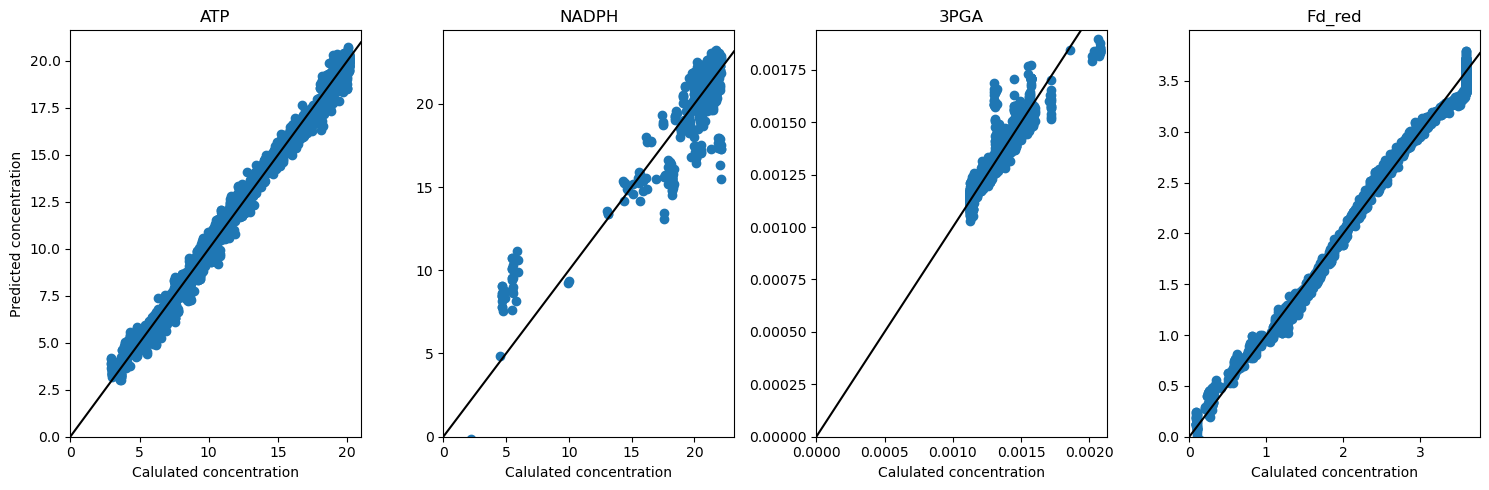

In [5]:
fig, axes = plt.subplots(1,4, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
    ax.set_xlabel("Calulated concentration")
    if i == 0:
        ax.set_ylabel("Predicted concentration")
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(result.columns[i])

    min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

    ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

fig.tight_layout()

In [6]:
# import pickle
# with open("../Results/concentration_regression_model.pickle", "wb") as f:
#     pickle.dump(model, f)

# Photosynthesis estimation function

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- **Light intensity & spectrum (400-700 nm)**
- Pigment concentrations: **Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin**
- Use the **measured absorption spectrum to calculate the light attenuation**
- NOT Chlorophyll concentration in sample cuvette BUT **Cell density in cells/ml**

### Output

NOT Concentrations BUT **Rates of ATP, NADPH, 3PGA, Fd_red**

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

import traceback
import logging

import pebble
from concurrent import futures

from function_concentration_regression import make_light_into_input

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"rateregression_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 2

target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]

# Setup the email sender
email = SMTPMailSender(
    SMTPserver='mail.gmx.net',
    username='tobiaspfennig@gmx.de',
    default_destination='tobiaspfennig@gmx.de'
)

email.send_email(
    body=f"Regression run {file_prefix} was successfully started",
    subject="Regression started"
)

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    logger = logging.getLogger(name)
    logger.setLevel(level)

    if len(logger.handlers) == 0:
        handler = logging.FileHandler(log_file)        
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    return logger

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

_m = get_model(get_y0=False, verbose=False, check_consistency=False)

## Get the values of the varied pigment contents
# Get the pigments in the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)
pigments = _m.parameters["pigment_content"]
_index = pigments.index

# Get onl the non-chlorophll compounds and reshape to allow for dot product
pigments = pigments.iloc[1:].to_numpy().reshape(-1,1)


# Make dot product with vector sapling a range of possible values 
pigments = pigments.dot(np.logspace(-np.log10(5), np.log(5), n_points).reshape(1,-1))
pigments = pd.DataFrame(pigments, index = _index[1:]).T

light_input = np.array(np.meshgrid(
    _light_input, # complex_abs_ps1
    _light_input, # complex_abs_ps2
    _light_input, # complex_abs_pbs
    _light_input, # light_ocp
    pigments["phycocyanin"], # phycocyanin
    pigments["allophycocyanin"], # allophycocyanin
    pigments["beta_carotene"], # beta-carotene
    range(len(target_compounds)), # target_compound
)).T.reshape(-1,8)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp",
        "pigment_phycocyanin",
        "pigment_allophycocyanin",
        "pigment_beta_carotene",
        "target_compound"
    ]
)

light_input["target_compound"] = pd.Series([target_compounds[int(x)] for x in light_input["target_compound"]], dtype=str)

light_input.shape[0]

# Add a sink reaction with Mass Action kinetics to the model
def vsink_hill(k, *X):
    concs = X[:len(X)//2]
    Ks = X[len(X)//2:]

    if len(concs) != len(Ks):
        raise ValueError("differing numbers of concentrations and Hill constants given")

    res = k
    for conc, K in zip(concs, Ks):
        res*= rf.hill(S=conc, vmax=1, kd=K, n=4)

    return res

def vcap(S, k, thresh, lower_cap=False):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    if not lower_cap:
        v[v<0] = 0
    return v

def add_sink_allcap(m, target_compound, all_target_compounds, k=10000):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add caps for all non-target compounds
    for cap in [x for x in all_target_compounds if x != target_compound]:
        # Set the stoichiometry
        if cap == "NADPH":
            cap_stoich = {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            }
        if cap == "Fd_red":
            cap_stoich = {"Fd_ox": 1}
        else:
            cap_stoich = {cap:-1}

        # Set the cap level
        if cap == "3PGA":
            cap_thresh = 1000
        elif cap == "ATP":
            cap_thresh = 0.95 * m.get_parameter("AP_tot")
        elif cap == "NADPH":
            cap_thresh = 0.95 * m.get_parameter("NADP_tot")
        elif cap == "Fd_red":
            cap_thresh = 0.95 * m.get_parameter("Fd_tot")


        m.add_parameters({
            f"kCap_{cap}": 10000,
            f"threshCap_{cap}": cap_thresh,
            f"lowerCap_{cap}": False,
        })
        
        m.add_reaction_from_args(
            rate_name=f"vout_{cap}",
            function=vcap,
            stoichiometry=cap_stoich,
            args=[cap, f"kCap_{cap}", f"threshCap_{cap}", f"lowerCap_{cap}"]
        )

    # Define the stoichiometry necessary for the sink reaction and the compounds that should be used for the kinetic function
    # Add the sink parameters and cap 3PGA, ATP and NADPH
    m.add_parameters({
        "kSink": k,
    })

    # Set the stoichiometry
    if target_compound == "NADPH":
        stoich = {
        "NADPH": -1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    elif target_compound == "Fd_red":
        stoich = {
        "Fd_ox": 1,
        "Fd_red":-1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    else:
        stoich = {target_compound:-1}
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    # Define the hill constants for the different compounds
    KHills = {
        # "Q_red":(0.1 * m.parameters["Q_tot"])**4,
        # "PC_red": (0.1 *m.parameters["PC_tot"])**4,
        "Fd_red": (0.1 *m.parameters["Fd_tot"])**4,
        "NADPH": (0.1 *m.parameters["NADP_tot"])**4,
        # "NADH": (0.1 *m.parameters["NAD_tot"])**4,
        "ATP": (0.1 *m.parameters["AP_tot"])**4,
        "3PGA": 1,
        "Ho": (0.001)**4
    }

    if len(modelstoich) != len(vargs):
        raise ValueError(f"stoichiometry unbalanced: {stoich}, {target_compound}")

    # Select ne needed Hill constants
    Kargs = {f"KSink_{comp}":KHills[comp] for comp in vargs}

    # Add the necessary parameters to the model
    m.add_parameters(Kargs)

    m.add_reaction_from_args(
        rate_name=f"vout_{target_compound}",
        function=vsink_hill,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs + list(Kargs.keys())
    )

    return m
    
def get_ss_rates(x, p_keys, all_target_compounds=target_compounds, file_prefix=file_prefix):
    index = x[0]
    p_values = x[1][:-1]
    target_compound = x[1][-1]
    
    # Define the rates that should be measured
    rates = [f"vout_{x}" for x in all_target_compounds]

    # Adapt the model to the target compound
    # Get the default model
    m, y0 = get_model(verbose=False, check_consistency=False)
    m, y0 = make_light_into_input(m, y0, verbose=False)

    # Set the initial 3PGA concentration to zero
    y0["3PGA"] = 0

    # Add sinks and caps to the model
    m = add_sink_allcap(m, target_compound=target_compound, all_target_compounds=all_target_compounds, k=1e6)

    # Create parameters from everything but the pigment contents 
    _p = dict(zip(p_keys, p_values.to_numpy()))
    p = {k:v for k,v in _p.items() if not k.startswith("pigment_")}

    # Add the pigment contents
    p.update({
        "pigment_content": pd.Series({
            "chla": 1, # This is always 1
            "beta_carotene": _p["pigment_beta_carotene"],
            "phycocyanin": _p["pigment_phycocyanin"],
            "allophycocyanin":_p["pigment_allophycocyanin"]
        })
    })

    print(p)

    # Adapt and initialise the simulator
    s = Simulator(m)
    s.update_parameters(p)
    s.initialise(y0)
    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the rates 
    if t is not None:
        res = s.get_fluxes_df()
        rates = res.loc[:, rates].iloc[-1]
    else:
        rates = pd.Series(index=rates)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in rates.to_numpy()])}\n")

    return index, rates

# if __name__ == "__main__":
#     # Setup logging
#     InfoLogger = InfoLogger = setup_logger("InfoLogger", Path(f"../out/{file_prefix}_info.log"), level=logging.INFO)
#     ErrorLogger = setup_logger("ErrorLogger", Path(f"../out/{file_prefix}_err.log"), level=logging.ERROR)

#     # Log the start of the run
#     InfoLogger.info("Started run")

#     input = light_input.iterrows()# .to_numpy()
#     result = pd.DataFrame(index=light_input.index, columns=[f"vout_{x}" for x in target_compounds])

#     # Partially populate the function
#     _get_ss_rates = partial(
#         get_ss_rates,
#         p_keys=light_input.columns,
#     )

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
        
#         try:
#             print(light_input.shape[0])
#             with tqdm(total=light_input.shape[0], disable=True) as pbar:
#                 with pebble.ProcessPool(max_workers=max_workers) as pool:
#                     future = pool.map(_get_ss_rates, input, timeout=20)
#                     it = future.result()
                    
#                     while True:
#                         try:
#                             index, res = next(it)
#                             pbar.update(1)
#                             result.loc[index,:] = res
#                         except futures.TimeoutError:
#                             pbar.update(1)
#                         except StopIteration:
#                             break
#                         except Exception as e:
#                             pbar.update(1)
#                             ErrorLogger.error("Error encountered in residuals\n" + str(traceback.format_exc()))
#                         finally:
#                             pbar.update(1)

#             n_successful = np.invert(result.isna().any(axis=1)).sum()

#             # Save the parameters and results
#             light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
#             result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

#             InfoLogger.info("Finished run successfully.")

#             email.send_email(
#                 body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
#                 subject="Regression finished"
#             )


#         except Exception as e:
#             ErrorLogger.error("Error encountered in Monte Carlo function\n" + str(traceback.format_exc()))
#             InfoLogger.info("Finished run with Error")
            
#             email.send_email(
#                 body=f"Monte Carlo run {file_prefix} encountered an Error:\n{e}",
#                 subject=f"Monte Carlo run Error"
#             )

Aborted
making absorption direct input
Aborted


In [ ]:
# Default ss rates
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

import traceback
import logging

import pebble
from concurrent import futures

from function_concentration_regression import make_light_into_input
from functions import add_exchange

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"rateregression_defaultss_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 2

target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]

# Setup the email sender
email = SMTPMailSender(
    SMTPserver='mail.gmx.net',
    username='tobiaspfennig@gmx.de',
    default_destination='tobiaspfennig@gmx.de'
)

email.send_email(
    body=f"Regression run {file_prefix} was successfully started",
    subject="Regression started"
)

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    logger = logging.getLogger(name)
    logger.setLevel(level)

    if len(logger.handlers) == 0:
        handler = logging.FileHandler(log_file)        
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    return logger

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

_m = get_model(get_y0=False, verbose=False, check_consistency=False)

## Get the values of the varied pigment contents
# Get the pigments in the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)
pigments = _m.parameters["pigment_content"]
_index = pigments.index

# Get onl the non-chlorophll compounds and reshape to allow for dot product
pigments = pigments.iloc[1:].to_numpy().reshape(-1,1)


# Make dot product with vector sapling a range of possible values 
pigments = pigments.dot(np.logspace(-np.log10(5), np.log(5), n_points).reshape(1,-1))
pigments = pd.DataFrame(pigments, index = _index[1:]).T

light_input = np.array(np.meshgrid(
    _light_input, # complex_abs_ps1
    _light_input, # complex_abs_ps2
    _light_input, # complex_abs_pbs
    _light_input, # light_ocp
    pigments["phycocyanin"], # phycocyanin
    pigments["allophycocyanin"], # allophycocyanin
    pigments["beta_carotene"], # beta-carotene
)).T.reshape(-1,7)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp",
        "pigment_phycocyanin",
        "pigment_allophycocyanin",
        "pigment_beta_carotene",
    ]
)

light_input.shape[0]

def get_ss_rates(x, p_keys, all_target_compounds=target_compounds, file_prefix=file_prefix):
    index = x[0]
    p_values = x[1]
    
    # Define the rates that should be measured
    target_compound_map={
        "ATP": "ATP",
        "NADPH": "NADPH",
        "Fd_red": "Fd_ox",
        "3PGA": "3PGA"
    }

    # Adapt the model to the target compound
    # Get the default model with an export of 3PGA
    m, y0 = get_model(verbose=False, check_consistency=False)
    m = add_exchange(m)
    m, y0 = make_light_into_input(m, y0, verbose=False)

    # Set the initial 3PGA concentration to zero
    y0["3PGA"] = 0

    # Create parameters from everything but the pigment contents 
    _p = dict(zip(p_keys, p_values.to_numpy()))
    p = {k:v for k,v in _p.items() if not k.startswith("pigment_")}

    # Add the pigment contents
    p.update({
        "pigment_content": pd.Series({
            "chla": 1, # This is always 1
            "beta_carotene": _p["pigment_beta_carotene"],
            "phycocyanin": _p["pigment_phycocyanin"],
            "allophycocyanin":_p["pigment_allophycocyanin"]
        })
    })

    # Adapt and initialise the simulator
    s = Simulator(m)
    s.update_parameters(p)
    s.initialise(y0)
    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the rates 
    if t is not None:
        res = s.get_fluxes_df().iloc[0]
        _st=m.get_stoichiometric_df()
        
        rates={}
        for k in all_target_compounds:
            rate = res * _st.loc[target_compound_map[k],:]
            rate = rate[rate>0].sum()
            rates[k] = rate

        rates= pd.Series(rates)
    else:
        rates = pd.Series(index=rates)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in rates.to_numpy()])}\n")

    return index, rates

if __name__ == "__main__":
    # Setup logging
    InfoLogger = InfoLogger = setup_logger("InfoLogger", Path(f"../out/{file_prefix}_info.log"), level=logging.INFO)
    ErrorLogger = setup_logger("ErrorLogger", Path(f"../out/{file_prefix}_err.log"), level=logging.ERROR)

    # Log the start of the run
    InfoLogger.info("Started run")

    email.send_email(
        body=f"Regression run {file_prefix} was successfully started",
        subject="Regression started"
    )

    input = light_input.iterrows()# .to_numpy()
    result = pd.DataFrame(index=light_input.index, columns=target_compounds)

    # Partially populate the function
    _get_ss_rates = partial(
        get_ss_rates,
        p_keys=light_input.columns,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            print(light_input.shape[0])
            with tqdm(total=light_input.shape[0], disable=True) as pbar:
                with pebble.ProcessPool(max_workers=max_workers) as pool:
                    future = pool.map(_get_ss_rates, input, timeout=20)
                    it = future.result()
                    
                    while True:
                        try:
                            index, res = next(it)
                            pbar.update(1)
                            result.loc[index,:] = res
                        except futures.TimeoutError:
                            pbar.update(1)
                        except StopIteration:
                            break
                        except Exception as e:
                            pbar.update(1)
                            ErrorLogger.error("Error encountered in residuals\n" + str(traceback.format_exc()))
                        finally:
                            pbar.update(1)

            n_successful = np.invert(result.isna().any(axis=1)).sum()

            # Save the parameters and results
            light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
            result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

            InfoLogger.info("Finished run successfully.")

            email.send_email(
                body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
                subject="Regression finished"
            )


        except Exception as e:
            ErrorLogger.error("Error encountered in Regression function\n" + str(traceback.format_exc()))
            InfoLogger.info("Finished run with Error")
            
            email.send_email(
                body=f"Regression run {file_prefix} encountered an Error:\n{e}",
                subject=f"Regression run Error"
            )

Aborted
128


In [ ]:
result

In [ ]:
get_ss_rates(
    [1, light_input.iloc[1]],
    light_input.columns,
    target_compounds
)

## Fit the regression function

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [5]:
run_prefix = "rateregression_defaultss_202407080958"

results = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
inputs = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

In [ ]:
results

In [ ]:
results.plot(subplots=True)

In [ ]:


target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]
models = {}

# Plot the residuals
fig, axes = plt.subplots(4,4, figsize=(15,15))

for target_compound, _axes in zip(target_compounds, axes):
    print(target_compound)

    result = results.loc[inputs["target_compound"] == target_compound]
    input = inputs.loc[inputs["target_compound"] == target_compound].iloc[:,:-1]

    # Exclude the failed simulations
    failed_simulations = result.isna().any(axis=1)

    # Generate some sample data
    X = input[np.invert(failed_simulations)]
    y = result.loc[np.invert(failed_simulations), :].to_numpy()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Degree of the polynomial
    degree = 5

    # Create polynomial features
    polynomial_features = PolynomialFeatures(degree=degree)

    # Create a base regressor
    base_regressor = LinearRegression()

    # Wrap the regressor with MultiOutputRegressor
    multi_target_regressor = MultiOutputRegressor(base_regressor)

    # Create a pipeline that combines the polynomial features and the linear regression model
    model = make_pipeline(polynomial_features, multi_target_regressor)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Save the model
    models[target_compound] = model

    for i, ax in enumerate(_axes.flatten()):
        ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
        ax.set_xlabel("Calulated rate")
        if i == 0:
            ax.set_ylabel(f"Target compound: {target_compound}\nPredicted rate")
        ax.set_xlim(0)
        ax.set_ylim(0)
        ax.set_title(result.columns[i])

        min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

        ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

    fig.tight_layout()

In [11]:
import pickle
with open("../Results/rate_regression_model.pickle", "wb") as f:
    pickle.dump(models, f)

## Predict the rates

In [177]:
import pickle
import pandas as pd
import sys

sys.path.append("../Code")
import functions_light_absorption as lip
from parameters import p
from module_electron_transport_chain import complex_absorption
from module_update_phycobilisomes import OCP_absorbed_light

# Load the regression model
with open("../Results/rate_regression_model.pickle", "rb") as f:
    models = pickle.load(f)

# Define the function that retrieves the predicted concentrations
def get_simulated_ssrates(
    light:pd.Series, 
    pigment_content=p["pigment_content"],
    rate_ratios = None,
    ps_ratio:float=5.9, # Value in the default model
    models=models,
    output_rates=["ATP", "NADPH", "3PGA", "Fd_red"],
):
    # Calculate the absorbed lights from the light input
    complex_abs = complex_absorption(light, ps_ratio, pigment_content)
    light_params = {f"complex_abs_{k}":v for k,v in complex_abs.items()}

    # Calculate the OCP absorbed light
    light_params["light_ocp"] = OCP_absorbed_light(light)

    # get the input parameters for the model
    model_input = light_params.copy()

    # Include the pigment content
    pigment_input = pigment_content.loc[["phycocyanin", "allophycocyanin", "beta_carotene"]].to_dict()
    pigment_input = {f"pigment_{k}":v for k,v in pigment_input.items()}
    model_input.update(pigment_input)

    # return model_input
    model_input = pd.DataFrame(model_input, index=[1])

    # Create a container for the results
    res = pd.DataFrame(
        columns=pd.Index(models.keys(), name="target_compound"),
        index=pd.Index(output_rates, name="production_rate")
    )

    for nam, model in models.items():
        # Predict the model simulated ss rates
        res[nam] = model.predict(model_input).flatten()

    # Return the ratios
    if rate_ratios is None:
        return res
    elif isinstance(rate_ratios, str) and rate_ratios == "sum":
        return res.sum(axis=1)
    elif isinstance(rate_ratios, (pd.Series, dict)):
        rate_ratios = pd.Series(rate_ratios)
        return (res * rate_ratios).sum(axis=1)
    else:
        raise ValueError(f"uncrecognized input for rate_ratios: {rate_ratios}")

In [178]:
rates = get_simulated_ssrates(lip.light_spectra("solar", 100), rate_ratios={"ATP":0.1, "NADPH": 0.5, "Fd_red":0.1, "3PGA":0.3})

# Model with biomass reaction to predict steady-state rates [current]

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

Use the submitted model version. A biomass function is added to reach steady state and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- Light spectrum & intensity (400-700 nm)
- Pigment concentrations: Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin
- Chlorophyll concentration in sample cuvette

### Output

Outflux rates of ATP, NADPH, 3PGA, and $Fd_{red}$

In [221]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

import traceback
import logging

import pebble
from concurrent import futures

from function_concentration_regression import make_light_into_input

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"rateregression_biomass_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 2#5

target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]
target_fluxes = ["vBiomass", "vATPconsumption"]

In [222]:
# Biomass composition computed by Andreas
# Simulated with Knoop model
biomass_Andreas = { # [mmol gDW^-1] Simulated with Knoop model
    "NADPH": -0.7742315014802865,
    "ATP": -2.9239579952574983,
    "Fd_red": -2.2950680206898717,
    "3PGA": -6.933834015281351,
}

In [223]:
def convert_biomass(biomass_stoich):
    res = biomass_stoich.copy()
    if "Ho" not in biomass_stoich:
        res["Ho"] = 0
    if "NADPH" in biomass_stoich:
        res["Ho"] = res["Ho"] + res["NADPH"] / m.get_parameter("bHo")
    if "Fd_red" in biomass_stoich:
        res["Ho"] = res["Ho"] + res["Fd_red"] / m.get_parameter("bHo")
        res["Fd_ox"] = - res["Fd_red"]
        res.pop("Fd_red")

    return res

In [224]:
def add_biomass_reaction(m, biomass_stoich, k_biomass):
    # Add parameter(s) and reaction to model
    m.add_parameter("k_biomass", k_biomass)
    m.add_reaction_from_args(
        "vBiomass",
        function = rf.mass_action_variable,
        stoichiometry = biomass_stoich,
        args = ["k_biomass"] + list(biomass_stoich.keys()),
    )
    return m

In [ ]:
# Setup the email sender
email = SMTPMailSender(
    SMTPserver='mail.gmx.net',
    username='tobiaspfennig@gmx.de',
    default_destination='tobiaspfennig@gmx.de'
)

email.send_email(
    body=f"Regression run {file_prefix} was successfully started",
    subject="Regression started"
)

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    logger = logging.getLogger(name)
    logger.setLevel(level)

    if len(logger.handlers) == 0:
        handler = logging.FileHandler(log_file)        
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    return logger

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

_m = get_model(get_y0=False, verbose=False, check_consistency=False)

## Get the values of the varied pigment contents
# Get the pigments in the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)
pigments = _m.parameters["pigment_content"]
_index = pigments.index

# Get onl the non-chlorophll compounds and reshape to allow for dot product
pigments = pigments.iloc[1:].to_numpy().reshape(-1,1)


# Make dot product with vector sapling a range of possible values 
pigments = pigments.dot(np.logspace(-np.log10(5), np.log(5), n_points).reshape(1,-1))
pigments = pd.DataFrame(pigments, index = _index[1:]).T

light_input = np.array(np.meshgrid(
    _light_input, # complex_abs_ps1
    _light_input, # complex_abs_ps2
    _light_input, # complex_abs_pbs
    _light_input, # light_ocp
    pigments["phycocyanin"], # phycocyanin
    pigments["allophycocyanin"], # allophycocyanin
    pigments["beta_carotene"], # beta-carotene
)).T.reshape(-1,7)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp",
        "pigment_phycocyanin",
        "pigment_allophycocyanin",
        "pigment_beta_carotene",
    ]
)
    
def get_ss_rates(x, p_keys, k_biomass=10, target_compounds=target_compounds, target_fluxes=target_fluxes, file_prefix=file_prefix):
    index = x[0]
    p_values = x[1]

    # Adapt the model to the target compound
    # Get the default model
    m, y0 = get_model(verbose=False, check_consistency=False)
    m, y0 = make_light_into_input(m, y0, verbose=False)

    # Lower metabolic ATP consumption
    # m.remove_reaction("vATPconsumption")
    m.update_parameter("kATPconsumption", 1e-2)

    # Set the initial 3PGA concentration to zero
    y0["3PGA"] = 0

    # Add biomass reaction
    m = add_biomass_reaction(
        m=m,
        biomass_stoich=convert_biomass(biomass_Andreas),
        k_biomass=k_biomass
    )
    # m = add_biomass_reaction_MM(m=m, biomass_stoich=biomass_Andreas, k_biomass=k_biomass)

    # Create parameters from everything but the pigment contents 
    _p = dict(zip(p_keys, p_values.to_numpy()))
    p = {k:v for k,v in _p.items() if not k.startswith("pigment_")}

    # Add the pigment contents
    p.update({
        "pigment_content": pd.Series({
            "chla": 1, # This is always 1
            "beta_carotene": _p["pigment_beta_carotene"],
            "phycocyanin": _p["pigment_phycocyanin"],
            "allophycocyanin":_p["pigment_allophycocyanin"]
        })
    })

    # Adapt and initialise the simulator
    s = Simulator(m)
    s.update_parameters(p)
    s.initialise(y0)
    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the rates 
    if t is not None:
        _res =-(
            s.model.get_stoichiometric_df()
            * s.get_fluxes_df().iloc[-1]
        )[target_fluxes].sum(axis=1)

        rates = _res[[x for x in target_compounds if x not in ["Fd_red"]]].copy()
        rates["Fd_red"] = -_res["Fd_ox"]
    else:
        rates = pd.Series(index=target_compounds)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in rates.to_numpy()])}\n")

    return index, rates


In [ ]:

if __name__ == "__main__":
    # Setup logging
    InfoLogger = InfoLogger = setup_logger("InfoLogger", Path(f"../out/{file_prefix}_info.log"), level=logging.INFO)
    ErrorLogger = setup_logger("ErrorLogger", Path(f"../out/{file_prefix}_err.log"), level=logging.ERROR)

    # Log the start of the run
    InfoLogger.info("Started run")

    input = light_input.iterrows()# .to_numpy()
    result = pd.DataFrame(index=light_input.index, columns=target_compounds)

    # Partially populate the function
    _get_ss_rates = partial(
        get_ss_rates,
        p_keys=light_input.columns,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            print(light_input.shape[0])
            with tqdm(total=light_input.shape[0], disable=True) as pbar:
                with pebble.ProcessPool(max_workers=max_workers) as pool:
                    future = pool.map(_get_ss_rates, input, timeout=20)
                    it = future.result()
                    
                    while True:
                        try:
                            index, res = next(it)
                            pbar.update(1)
                            result.loc[index,:] = res
                        except futures.TimeoutError:
                            pbar.update(1)
                        except StopIteration:
                            break
                        except Exception as e:
                            pbar.update(1)
                            ErrorLogger.error("Error encountered in residuals\n" + str(traceback.format_exc()))
                        finally:
                            pbar.update(1)

            n_successful = np.invert(result.isna().any(axis=1)).sum()

            # Save the parameters and results
            light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
            result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

            InfoLogger.info("Finished run successfully.")

            email.send_email(
                body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
                subject="Regression finished"
            )


        except Exception as e:
            ErrorLogger.error("Error encountered in Monte Carlo function\n" + str(traceback.format_exc()))
            InfoLogger.info("Finished run with Error")
            
            email.send_email(
                body=f"Monte Carlo run {file_prefix} encountered an Error:\n{e}",
                subject=f"Monte Carlo run Error"
            )

### Tests

In [99]:
import pickle
import pandas as pd
import sys

sys.path.append("../Code")
import functions_light_absorption as lip
from parameters import p
from module_electron_transport_chain import complex_absorption
from module_update_phycobilisomes import OCP_absorbed_light

from functions_light_absorption import get_pigment_absorption, light_spectra, get_mean_sample_light
from modelbase.ode import Model
from modelbase.ode import ratefunctions as rf

In [ ]:
# Inputs
m, y0 = get_model()

ps_ratio:float=5.9
pigment_content = m.parameters["pigment_content"]
k_biomasses = [2, 10, 50]

In [101]:
n_intens = 5
intensities = np.linspace(10,1000, n_intens)

biomasses = pd.DataFrame(index=intensities, columns=k_biomasses)
ss_compounds= pd.DataFrame(index=pd.MultiIndex.from_product([k_biomasses, intensities]), columns = target_compounds)

for k_biomass in k_biomasses:
    for i in intensities:
        light = lip.light_spectra("warm_white_led", i)

        complex_abs = complex_absorption(light, ps_ratio, pigment_content)
        light_params = {f"complex_abs_{k}":v for k,v in complex_abs.items()}

        # Calculate the OCP absorbed light
        light_params["light_ocp"] = OCP_absorbed_light(light)

        # Adapt the model to the target compound
        # Get the default model
        m, y0 = get_model(verbose=False, check_consistency=False)
        m, y0 = make_light_into_input(m, y0, verbose=False)

        # Set the initial 3PGA concentration to zero
        y0["3PGA"] = 0

        # Add biomass reaction
        m = add_biomass_reaction(
            m=m,
            biomass_stoich=convert_biomass(biomass_Andreas),
            k_biomass=k_biomass
        )

        # Adapt and initialise the simulator
        s = Simulator(m)
        s.update_parameters(light_params)
        s.initialise(y0)
        # print(index, p)

        integrator_kwargs = {
            "maxsteps": 20000,
            "atol": 1e-9,
            "rtol": 1e-9,
            "maxnef": 10,
            "maxncf": 10,
        }

        # t,y = s.simulate(1e6, **integrator_kwargs)

        # Simulate to steady state
        s, t, y = simulate_to_steady_state_custom(
            s,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": False,
            },
            rel_norm=True,
            return_simulator=True,
            **integrator_kwargs,
        )

        biomasses.loc[i, k_biomass] = s.get_fluxes_df().loc[:, "vBiomass"].iloc[0]


        ss_compounds.loc[(k_biomass, i)] = s.get_full_results_df().loc[:, target_compounds].iloc[0]

In [102]:
from pandas import IndexSlice as idx
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(len(k_biomasses), sharex=True, figsize=(7, 10))

for k_biomass, ax in zip(k_biomasses, axes.flatten()):
    ax.plot(ss_compounds.loc[idx[k_biomass, :]], label=ss_compounds.columns)
    ax.set_title(f"Rate constant = {k_biomass}")

axes[0].legend(bbox_to_anchor=(1,1))

axes[-1].set_xlabel("Warm white led light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")

for ax in axes:
    ax.set_ylabel("Steady-state concentration\n[mmol mol(Chl)$^{-1}$]")

In [ ]:
ss_compounds.loc[idx[k_biomass, :], "ATP"].unstack().T.plot()

In [ ]:
from turtle import title


fig, axes = plt.subplots(len(target_compounds), sharex=True, figsize=(7, 10))

for target_compound, ax in zip(target_compounds, axes.flatten()):
    ax.plot(ss_compounds.loc[:, target_compound].unstack().T, label=k_biomasses)
    ax.set_title(f"{target_compound}")

axes[0].legend(bbox_to_anchor=(1,1), title="Rate constant")

axes[-1].set_xlabel("Warm white led light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")

for ax in axes:
    ax.set_ylabel("Steady-state concentration\n[mmol mol(Chl)$^{-1}$]")

In [ ]:
fig, axes = plt.subplots(len(target_compounds), sharex=True, figsize=(7, 10))

for target_compound, ax in zip(target_compounds, axes.flatten()):
    ax.plot(ss_compounds.loc[:, target_compound].unstack().T, label=k_biomasses)
    ax.set_title(f"{target_compound}")

axes[0].legend(bbox_to_anchor=(1,1), title="Rate constant")

axes[-1].set_xlabel("Warm white led light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")

for ax in axes:
    ax.set_ylabel("Steady-state concentration\n[mmol mol(Chl)$^{-1}$]")

In [ ]:
ax = biomasses.plot()
ax.set_xlabel("Warm white led light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
ax.set_ylabel("Steady-state Biomass flux\n[mmol mol(Chl)$^{-1}$ s$^{-1}$]")

## Fit the regression function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [2]:
run_prefix = "rateregression_biomass_202410211718"

results = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
inputs = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

In [ ]:
results.plot(subplots=True)

In [ ]:
target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]
models = {}

# Plot the residuals
fig, axes = plt.subplots(1,len(target_compounds), figsize=(15,5))

result = results
input = inputs

# Exclude the failed simulations
failed_simulations = result.isna().any(axis=1)
print(f"{(failed_simulations.sum() / failed_simulations.shape[0]) * 100} % failed simulations")

# Generate some sample data
X = input[np.invert(failed_simulations)]
y = result.loc[np.invert(failed_simulations), :].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree of the polynomial
degree = 5

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=degree)

# Create a base regressor
base_regressor = LinearRegression()

# Wrap the regressor with MultiOutputRegressor
multi_target_regressor = MultiOutputRegressor(base_regressor)

# Create a pipeline that combines the polynomial features and the linear regression model
model = make_pipeline(polynomial_features, multi_target_regressor)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

for i in range(len(target_compounds)):
    ax = axes[i]
    ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
    ax.set_xlabel("Calulated rate")
    # if i == 0:
    #     ax.set_ylabel(f"Target compound: {target_compound}\nPredicted rate")
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(result.columns[i])

    min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

    ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

fig.tight_layout()

In [14]:
import pickle
with open("../Results/rate_regression_model_biomass.pickle", "wb") as f:
    pickle.dump(model, f)

### Prediction

In [ ]:
# Predict the concentrations for m a regression model 
import pickle
import pandas as pd
import sys

sys.path.append("../Code")
import functions_light_absorption as lip
from parameters import p
from module_electron_transport_chain import complex_absorption
from module_update_phycobilisomes import OCP_absorbed_light

from functions_light_absorption import get_pigment_absorption, light_spectra, get_mean_sample_light
from modelbase.ode import Model
from modelbase.ode import ratefunctions as rf
# Load the regression model
with open("../synechocystis-photosynthesis-2024/Results/rate_regression_model_biomass.pickle", "rb") as f:
    models = pickle.load(f)

# Define the function that retrieves the predicted concentrations
def get_simulated_ssrates(
    light:pd.Series, 
    pigment_content=p["pigment_content"],
    ps_ratio:float=5.9, # Value in the default model
    model=model,
    output_rates=["ATP", "NADPH", "3PGA", "Fd_red"],
):
    # Calculate the absorbed lights from the light input
    complex_abs = complex_absorption(light, ps_ratio, pigment_content)
    light_params = {f"complex_abs_{k}":v for k,v in complex_abs.items()}

    # Calculate the OCP absorbed light
    light_params["light_ocp"] = OCP_absorbed_light(light)

    # get the input parameters for the model
    model_input = light_params.copy()

    # Include the pigment content
    pigment_input = pigment_content.loc[["phycocyanin", "allophycocyanin", "beta_carotene"]].to_dict()
    pigment_input = {f"pigment_{k}":v for k,v in pigment_input.items()}
    model_input.update(pigment_input)

    # return model_input
    model_input = pd.DataFrame(model_input, index=[1])

    # Create a container for the results
    res = pd.Series(
        model.predict(model_input).flatten(),
        index=pd.Index(output_rates, name="production_rate")
    )
    return res
    
# Funciton to get the required predictor inputs from Andreas model outputs
def get_model_inputs(
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        phycocyanin, # [µmol l^-1] FIXME: Not implemented yet
        allophycocyanin, # [µmol l^-1] FIXME: Not implemented yet
        light_intensity, # Model
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        beta_carotene_fraction = 0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        cell_volume = 4e-15, # [l]
    ):
    # Calculate the chlorophyll content
    mg_chlorophyll  = (chlorophyll*893.509/1000) # [mg l^-1]

    # Calculate the relative contents of carotenoids, phycocyanin, and allophycocyanin 
    relative_carotenoids = (carotenoids*581.5565/1000)/mg_chlorophyll # [mg mg(Chla)^-1]  581.5565 is weighted average mol weight of carotenoids
    relative_phycocyanin = 10000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now
    relative_allophycocyanin = 2000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now

    # Get the pigment content of the cell
    pigment_content = pd.Series({
        "chla": 1, # This is always 1
        "beta_carotene":relative_carotenoids,
        "phycocyanin": relative_phycocyanin,
        "allophycocyanin":relative_allophycocyanin
    })

    # Only beta carotene is photosynthetically active
    photopigment_content = pigment_content.copy()
    photopigment_content["beta_carotene"] = photopigment_content["beta_carotene"] * beta_carotene_fraction

    # Get the total cellular absorption
    absorption = get_pigment_absorption(pigment_content)
    absorption = absorption.sum(axis=1)
    
    # Define the input light
    light = light_spectra(which="warm_white_led", intensity=light_intensity) # The model light intensity is µmol(photons) m^-2 s^-1, correct?

    # Calculate the chlorophyll concentration in the sample [mg(Chl) m^-3]
    chlorophyll_sample = (
        chlorophyll # [µmol l^-1] intracellular
        * cell_volume # [l cell^-1]
        * cell_density # [cells ml^-1]
        * 1e6 # [ml m^-3]
        * 1e-3 # [mmol µmol^-1]
        * 893.509 # [g mol^-1]
        )

    # Correct the light for absorption
    corrected_light = get_mean_sample_light(
        I0=light, 
        depth=sample_depth_m, # [m]
        absorption_coef=absorption, # wavelength-specific absorption coefficients for whole cell, summed up from pigments
        chlorophyll_sample = chlorophyll_sample # [mg(Chl) m^-3]
    )
    return {
        "orig_pfd": light,
        "absorption_spectrum": absorption,
        "pfd": corrected_light,
        "pigment_content": photopigment_content
        }

# Wrapper function to get the rate estimations from Andreas model outputs
def get_influx_rate_estimations(
        light_intensity, # Model
        rate_ratios,
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        phycocyanin=None, # [µmol l^-1]
        allophycocyanin=None, # [µmol l^-1]
        ps_ratio:float=5.9,
        beta_carotene_fraction = 0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        cell_volume = 4e-15, # [l]
        models=models, # The predictor models
        output_rates=["ATP", "NADPH", "3PGA", "Fd_red"]
    ):
    # Get the inputs into the predictor function
    pred_input = get_model_inputs(
        cell_density=cell_density, # [cells ml^-1]
        chlorophyll=chlorophyll[-1], # [µmol l^-1]
        carotenoids=carotenoids[-1], # [µmol l^-1]
        phycocyanin=phycocyanin, # [µmol l^-1]
        allophycocyanin=allophycocyanin, # [µmol l^-1]
        light_intensity=light_intensity, # Model
        sample_depth_m=sample_depth_m, # [m] Assuming a cuvette with 1 cm diameter
        beta_carotene_fraction=beta_carotene_fraction, # [rel] fraction of beta-carotene of cellular carotenoids
        cell_volume=cell_volume, # [l]
    )

    # Predict the simulated rates
    rates = get_simulated_ssrates(
        light=pred_input["pfd"], 
        pigment_content=pred_input["pigment_content"],
        rate_ratios = rate_ratios,
        ps_ratio=ps_ratio, # Value in the default model
        models=models,
        output_rates=output_rates,
    )

    return rates

## Interface between Andreas model and the prediction function

### Getting the inputs into the prediction function

In [227]:
sys.path.append("..")
from functions_light_absorption import get_pigment_absorption, light_spectra, get_mean_sample_light, plot_spectra
from modelbase.ode import Model
from modelbase.ode import ratefunctions as rf

In [ ]:
# Create a mock model
m = Model()
# Add the compounds
m.add_compounds(["ATP", "NADPH", "3PGA", "Fd_red"])

# Add total pools or maximal concentrations
totals = {"ATP":"ATP_tot", "NADPH":"NADP_tot", "3PGA":"3PGA_max", "Fd_red":"Fd_tot"}

p = {
    "k_ATP": 5,
    "k_NADPH": 5,
    "k_3PGA": 5,
    "k_Fd_red": 5,
    "ATP_tot": 1,
    "NADP_tot": 1,
    "3PGA_max": 1,
    "Fd_tot": 1,

    "light":100, # [µmol(Photons) m^-2 s^-1] Light intensity (warm white LED) 
    "cell_density":1e8, # [cells ml^-1]
    "chlorophyll":10000, # [µmol l^-1]
    "carotenoids":3000, # [µmol l^-1]
    "phycocyanin":None, # [µmol l^-1]
    "allophycocyanin":None, # [µmol l^-1]
    "beta_carotene_fraction":0.26, # [rel] fraction of beta-carotene of cellular carotenoids
    "ps_ratio":5.9,
    "sample_depth_m":0.01, # [m] Assuming a cuvette with 1 cm diameter
    "cell_volume": 4e-15,
}
m.add_parameters(p)

def fraction(S, S_tot):
    return S/S_tot

# Add algebraic models
for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]:
    m.add_algebraic_module_from_args(
        f"{comp} fraction",
        function=fraction,
        derived_compounds=[f"{comp}_fraction"],
        args=[comp, totals[comp]]
    )

    m.add_reaction_from_args(
        f"{comp} consumption",
        function=rf.mass_action_1,
        stoichiometry={comp:-1},
        args=[f"k_{comp}", comp]
    )

m.add_parameter("light", 100)

In [ ]:
s=Simulator(m)
s.initialise({"ATP":1, "NADPH":0.9, "3PGA":0.8, "Fd_red":0.7})
s.simulate(1)
s.plot()

In [230]:
def get_model_inputs(
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        phycocyanin, # [µmol l^-1] FIXME: Not implemented yet
        allophycocyanin, # [µmol l^-1] FIXME: Not implemented yet
        light_intensity, # Model
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        beta_carotene_fraction = 0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        cell_volume = 4e-15, # [l]
    ):
    # Calculate the chlorophyll content
    mg_chlorophyll  = (chlorophyll*893.509/1000) # [mg l^-1]

    # Calculate the relative contents of carotenoids, phycocyanin, and allophycocyanin 
    relative_carotenoids = (carotenoids*581.5565/1000)/mg_chlorophyll # [mg mg(Chla)^-1]  581.5565 is weighted average mol weight of carotenoids
    relative_phycocyanin = 10000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now
    relative_allophycocyanin = 2000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now

    # Get the pigment content of the cell
    pigment_content = pd.Series({
        "chla": 1, # This is always 1
        "beta_carotene":relative_carotenoids,
        "phycocyanin": relative_phycocyanin,
        "allophycocyanin":relative_allophycocyanin
    })

    # Only beta carotene is photosynthetically active
    photopigment_content = pigment_content.copy()
    photopigment_content["beta_carotene"] = photopigment_content["beta_carotene"] * beta_carotene_fraction

    # Get the total cellular absorption
    absorption = get_pigment_absorption(pigment_content)
    absorption = absorption.sum(axis=1)
    
    # Define the input light
    light = light_spectra(which="warm_white_led", intensity=light_intensity) # The model light intensity is µmol(photons) m^-2 s^-1, correct?

    # Calculate the chlorophyll concentration in the sample [mg(Chl) m^-3]
    chlorophyll_sample = (
        chlorophyll # [µmol l^-1] intracellular
        * cell_volume # [l cell^-1]
        * cell_density # [cells ml^-1]
        * 1e6 # [ml m^-3]
        * 1e-3 # [mmol µmol^-1]
        * 893.509 # [g mol^-1]
        )

    # Correct the light for absorption
    corrected_light = get_mean_sample_light(
        I0=light, 
        depth=sample_depth_m, # [m]
        absorption_coef=absorption, # wavelength-specific absorption coefficients for whole cell, summed up from pigments
        chlorophyll_sample = chlorophyll_sample # [mg(Chl) m^-3]
    )
    return {
        "orig_pfd": light,
        "absorption_spectrum": absorption,
        "pfd": corrected_light,
        "pigment_content": photopigment_content
        }

### Wrapper function

In [231]:
def get_influx_rate_estimations(
        light_intensity, # Model
        rate_ratios,
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        phycocyanin=None, # [µmol l^-1]
        allophycocyanin=None, # [µmol l^-1]
        ps_ratio:float=5.9,
        beta_carotene_fraction = 0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        cell_volume = 4e-15, # [l]
        models=models, # The predictor models
        output_rates=["ATP", "NADPH", "3PGA", "Fd_red"]
    ):
    # Get the inputs into the predictor function
    pred_input = get_model_inputs(
        cell_density=cell_density, # [cells ml^-1]
        chlorophyll=chlorophyll, # [µmol l^-1]
        carotenoids=carotenoids, # [µmol l^-1]
        phycocyanin=phycocyanin, # [µmol l^-1]
        allophycocyanin=allophycocyanin, # [µmol l^-1]
        light_intensity=light_intensity, # Model
        sample_depth_m=sample_depth_m, # [m] Assuming a cuvette with 1 cm diameter
        beta_carotene_fraction=beta_carotene_fraction, # [rel] fraction of beta-carotene of cellular carotenoids
        cell_volume=cell_volume, # [l]
    )

    # Predict the simulated rates
    rates = get_simulated_ssrates(
        light=pred_input["pfd"], 
        pigment_content=pred_input["pigment_content"],
        rate_ratios = rate_ratios,
        ps_ratio=ps_ratio, # Value in the default model
        models=models,
        output_rates=output_rates,
    )

    return rates

In [ ]:
# Example output with all the maximal output rates of each compound in the columns
rates = get_influx_rate_estimations(
        light_intensity=m.parameters["light"], # Model
        rate_ratios=None,
        cell_density=1e8, # [cells ml^-1]
        chlorophyll=10000, # [µmol l^-1]
        carotenoids=3000, # [µmol l^-1]
        phycocyanin=None, # [µmol l^-1]
        allophycocyanin=None, # [µmol l^-1]
        beta_carotene_fraction=0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        ps_ratio=5.9,
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
    )
rates

### Add production to mock model

In [ ]:
def get_required_production_ratio(*args):
    frac = np.stack(args, axis=0)
    frac = 1 - frac
    rel_frac = frac / frac.sum(axis=0)
    return rel_frac

m.add_algebraic_module_from_args(
    "production ratios",
    function=get_required_production_ratio,
    derived_compounds=[f"{comp}_prodratio" for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]],
    args=[f"{comp}_fraction" for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]]
)

def _get_influx_rate_estimations(
        light_intensity, # Model
        ATP_prodratio, # Ratio of maximal ATP produciton that should be outputted
        NADPH_prodratio, # Ratio of maximal NADPH produciton that should be outputted
        _3PGA_prodratio, # Ratio of maximal 3PGA produciton that should be outputted
        Fd_red_prodratio, # Ratio of maximal Fd_red produciton that should be outputted
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        phycocyanin=None, # [µmol l^-1]
        allophycocyanin=None, # [µmol l^-1]
        ps_ratio:float=5.9,
        beta_carotene_fraction=0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        cell_volume = 4e-15, # [l]
):
    # Iterate through the given concentration fractions and determine 
    rates = []
    for ATP, NADPH, _3PGA, Fd_red in zip(ATP_prodratio, NADPH_prodratio, _3PGA_prodratio, Fd_red_prodratio):
        _rates = get_influx_rate_estimations(
            light_intensity=light_intensity, # Model
            rate_ratios=pd.Series([ATP, NADPH, _3PGA, Fd_red], index=["ATP", "NADPH", "3PGA", "Fd_red"]),
            cell_density=cell_density, # [cells ml^-1]
            chlorophyll=chlorophyll, # [µmol l^-1]
            carotenoids=carotenoids, # [µmol l^-1]
            phycocyanin=phycocyanin, # [µmol l^-1]
            allophycocyanin=allophycocyanin, # [µmol l^-1]
            beta_carotene_fraction=beta_carotene_fraction, # [rel] fraction of beta-carotene of cellular carotenoids
            ps_ratio=ps_ratio,
            sample_depth_m=sample_depth_m, # [m] Assuming a cuvette with 1 cm diameter
            cell_volume=cell_volume
        )
        rates.append(_rates)

    rates = pd.concat(rates, axis=1)
    return rates.to_numpy()

m.add_algebraic_module_from_args(
    "production_rates",
    function=_get_influx_rate_estimations,
    derived_compounds=["vATP_prod", "vNADPH_prod", "v3PGA_prod", "vFd_red_prod"],
    args=[
        "light",
        "ATP_prodratio",
        "NADPH_prodratio",
        "3PGA_prodratio",
        "Fd_red_prodratio",
        "cell_density",
        "chlorophyll",
        "carotenoids",
        "phycocyanin",
        "allophycocyanin",
        "beta_carotene_fraction",
        "ps_ratio",
        "sample_depth_m",
    ]
)

# Add algebraic models
for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]:
    m.add_reaction_from_args(
        f"{comp} production",
        function=rf.constant,
        stoichiometry={comp:1},
        args=[f"v{comp}_prod"]
    )

In [ ]:
s=Simulator(m)
s.initialise({"ATP":1, "NADPH":0.9, "3PGA":0.8, "Fd_red":0.7})
s.simulate(10)
s.plot()

In [ ]:
s.get_full_results_df()

In [204]:

# Default ss rates
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

import traceback
import logging

import pebble
from concurrent import futures

from function_concentration_regression import make_light_into_input
from functions import add_exchange

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

import matplotlib.pyplot as plt


def vsink_hill(k, *X):
    concs = X[:len(X)//2]
    Ks = X[len(X)//2:]

    if len(concs) != len(Ks):
        raise ValueError("differing numbers of concentrations and Hill constants given")

    res = k
    for conc, K in zip(concs, Ks):
        res*= rf.hill(S=conc, vmax=1, kd=K, n=4)

    return res

def vcap(S, k, thresh, lower_cap=False):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    if not lower_cap:
        v[v<0] = 0
    return v

def add_sink_allcap(m, target_compound, all_target_compounds, k=10000, cap_threshold=0.95):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add caps for all non-target compounds
    for cap in [x for x in all_target_compounds if x != target_compound]:
        # Set the stoichiometry
        if cap == "NADPH":
            cap_stoich = {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            }
        elif cap == "Fd_red":
            cap_stoich = {"Fd_ox": 1, "Ho": -1/m.get_parameter("bHo")}
        else:
            cap_stoich = {cap:-1}

        # Set the cap level
        if cap == "3PGA":
            cap_thresh = 1000
        elif cap == "ATP":
            cap_thresh = cap_threshold * m.get_parameter("AP_tot")
        elif cap == "NADPH":
            cap_thresh = cap_threshold * m.get_parameter("NADP_tot")
        elif cap == "Fd_red":
            cap_thresh = cap_threshold * m.get_parameter("Fd_tot")


        m.add_parameters({
            f"kCap_{cap}": 10000,
            f"threshCap_{cap}": cap_thresh,
            f"lowerCap_{cap}": False,
        })
        
        m.add_reaction_from_args(
            rate_name=f"vout_{cap}",
            function=vcap,
            stoichiometry=cap_stoich,
            args=[cap, f"kCap_{cap}", f"threshCap_{cap}", f"lowerCap_{cap}"]
        )

    # Define the stoichiometry necessary for the sink reaction and the compounds that should be used for the kinetic function
    # Add the sink parameters and cap 3PGA, ATP and NADPH
    m.add_parameters({
        "kSink": k,
    })

    # Set the stoichiometry
    if target_compound == "NADPH":
        stoich = {
        "NADPH": -1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    elif target_compound == "Fd_red":
        stoich = {
        "Fd_ox": 1,
        "Fd_red":-1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    else:
        stoich = {target_compound:-1}
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    # Define the hill constants for the different compounds
    KHills = {
        # "Q_red":(0.1 * m.parameters["Q_tot"])**4,
        # "PC_red": (0.1 *m.parameters["PC_tot"])**4,
        "Fd_red": (0.1 *m.parameters["Fd_tot"])**4,
        "NADPH": (0.1 *m.parameters["NADP_tot"])**4,
        # "NADH": (0.1 *m.parameters["NAD_tot"])**4,
        "ATP": (0.1 *m.parameters["AP_tot"])**4,
        "3PGA": 1,
        "Ho": (0.001)**4
    }

    if len(modelstoich) != len(vargs):
        raise ValueError(f"stoichiometry unbalanced: {stoich}, {target_compound}")

    # Select ne needed Hill constants
    Kargs = {f"KSink_{comp}":KHills[comp] for comp in vargs}

    # Add the necessary parameters to the model
    m.add_parameters(Kargs)

    m.add_reaction_from_args(
        rate_name=f"vout_{target_compound}",
        function=vsink_hill,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs + list(Kargs.keys())
    )

    return m

In [215]:
def test_sinkfunction(x):
    light_intensity, cap_threshold = x
    m, y0 = get_model(verbose=False, check_consistency=False)
    # m, y0 = make_light_into_input(m, y0, verbose=False)

    m.update_parameter(
        "pfd",
        lip.light_spectra("warm_white_led", light_intensity)
    )

    # Set the initial 3PGA concentration to zero
    y0["3PGA"] = 0

    target_compounds = ["3PGA", "ATP", "NADPH", "Fd_red"]# , ,] #, ]
    target_compound = "3PGA"

    # Add sinks and caps to the model
    m = add_sink_allcap(
        m, 
        target_compound=target_compound, 
        all_target_compounds=target_compounds, 
        k=1e6,
        cap_threshold=cap_threshold
    )

    s = Simulator(m)
    s.initialise(y0)
    t,y = s.simulate(1e6, **fnc.simulator_kwargs["loose"])
    if t is None:
        warnings.warn("No steady-state reached")

    return x, s.get_fluxes_df().loc[:, [f"vout_{cmp}" for cmp in target_compounds]].iloc[-1]

In [232]:
import itertools
from os import cpu_count
from tqdm.auto import tqdm


light_ints = np.linspace(50, 1000, 3)
threshs = np.linspace(0.3, 0.95, 10)
combin = itertools.product(light_ints, threshs)

In [ ]:
n_workers = 4
timeout = 300

results = {}
with tqdm(total= len(light_ints) * len(threshs), disable=False) as pbar:
    with pebble.ProcessPool(max_workers=n_workers if n_workers is not None else cpu_count()) as pool:
        future = pool.map(
            test_sinkfunction,
            combin,
            timeout=timeout,
        )
        it = future.result()

        while True:
            try:
                x, res = next(it)
                results[x] = res
                pbar.update(1)
            except futures.TimeoutError:
                warnings.warn("Timeout of a calculation")
                pbar.update(1)
            except StopIteration:
                break

In [ ]:
pd.DataFrame(results).T.groupby(level=0).plot()

In [246]:
from pandas import IndexSlice as idx

In [ ]:
pd.DataFrame(results).loc[:, idx[50, :]]

In [ ]:
pd.DataFrame(results).T.groupby(level=0).plot()

In [ ]:
plot_compounds = target_compounds + ["Q_red"]

caps = pd.Series({
    "3PGA": 1000,
    "ATP": 0.95 * m.get_parameter("AP_tot"),
    "NADPH": 0.95 * m.get_parameter("NADP_tot"),
    "Fd_red": 0.95 * m.get_parameter("Fd_tot"),
    "Q_red": 0.95 * m.get_parameter("Q_tot")
})

# Plot the relative compound concentrations
fig, ax = plt.subplots()

dat = s.get_full_results_df().loc[1000:, plot_compounds] / caps
dat.plot(ax=ax)

ax.legend()

ax.set_ylabel("Concentration relative to pool size [rel]")
ax.set_xlabel("Time [h]")